**CV2021 - week 9**

**CONTENTS**

* [Adaboost implmentation](https://colab.research.google.com/drive/145SrhPJGi1FJ5SRf_bAlX1GTVMEF8j5s#scrollTo=O4pckSUYeASd&line=9&uniqifier=1)
* [Viola Jones - tracking by detection](https://colab.research.google.com/drive/145SrhPJGi1FJ5SRf_bAlX1GTVMEF8j5s#scrollTo=6X5Zoc1x8Jg7&line=5&uniqifier=1)
* [Mean Shift tracking](https://colab.research.google.com/drive/145SrhPJGi1FJ5SRf_bAlX1GTVMEF8j5s#scrollTo=Zbn0ndBp3kug&line=6&uniqifier=1)
* [Lukas Kanade optical flow](https://colab.research.google.com/drive/145SrhPJGi1FJ5SRf_bAlX1GTVMEF8j5s#scrollTo=m7meiIHFOeBM&line=1&uniqifier=1)
* [Condensation tracking](https://colab.research.google.com/drive/145SrhPJGi1FJ5SRf_bAlX1GTVMEF8j5s#scrollTo=t8Lsz3fkXEhQ&line=4&uniqifier=1)

**Homework**

* **1bp** Analyze the *Harry Potter* eye/smile detector and it's failcases. Come with possible causes for this issue, based on the way variation is encoded and used in searching for matches. Propose a solution for the identified *eye detector* failcase.
* **1bp** To overcome the difficulty of MeanShift when the object orientation was changing dramatically, the CamShift algorithm was proposed. Experiment with *OpenCV* CamShift on a video sequence where MeanShift performs poorly.

* **1bp** Given a stereo-vision system and an obstacle detection problem, describe a pipeline used to decide if your moving object fits through the space between two identified obstacles. (No implementation needed. Describe how would you approach the given problem, based on the topics discussed in the exercise sessions). 



In [3]:
!pip install pyefd

In [4]:
import cv2 as cv
import numpy as np
import os
from pyefd import elliptic_fourier_descriptors


def load_dataset(dset_dir):
  # a dict to keep the class of each image
  image_index = {}

  for class_name in os.listdir(dset_dir):
    in_cat_images = []
    cat_dir_path = "{}/{}".format(dset_dir, class_name)
    for file_name in os.listdir(cat_dir_path):
      img_path = "{}/{}".format(cat_dir_path, file_name)
      img = cv.imread(img_path, 0) # open as grayscale
      if img is not None: # unless some corrupted images
        in_cat_images.append(img)
    image_index[class_name] = in_cat_images
  
  return image_index


# extracting and EFD feature should be done in 2 steps
# Coutours are to be detected, and then EFD is applied on contours
def extract_efd_feature(img):
  contours, _ = cv.findContours(img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
  fd = []
  for cnt in contours:
    coeffs = elliptic_fourier_descriptors(np.squeeze(cnt), order=10, normalize=True)
    fd.append(coeffs.flatten()[3:])
  return np.array(fd)


def prepare_data(image_set):
  X = []
  Y = []
  for img_class, img_list in image_set.items():
    for image in img_list:
      try:
        fdesc = extract_efd_feature(image)
        X.append(np.max(fdesc, axis=0)) # pooling strategy here (task 3)
        Y.append(int(img_class))
      except np.AxisError:
        continue # some corrupted images

  return np.array(X), np.array(Y)

In [5]:
def clf_error(y_true, y_pred, w):
  # computes clf error with respect to the weights w
  return 1/sum(w) * sum(w * np.not_equal(y_true, y_pred).astype(int))


def alpha(error):
  return np.log((1 - error) / error)


def update(w, alpha, y_true, y_pred):
  return w * np.exp(alpha * (np.not_equal(y_true, y_pred).astype(int)))

In [6]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier


class Adaboost:
  def __init__(self, num_rounds):
    self.alpha = []
    self.epsilon = []
    self.M  = num_rounds
    self.clfs = []

  def fit(self, X, Y):
    # remember to reset in case you fit multiple times
    self.alpha = []
    self.epsilon = []
    
    n = X.shape[0]
    for m in range(self.M):
      if m == 0:
        w_m = 1/n * np.ones(n) # uniform
      else:
        w_m = update(w_m, alpha_m, Y, preds)
      
      clf_m = DecisionTreeClassifier(max_depth=5)
      clf_m.fit(X, Y, sample_weight=w_m)
      preds = clf_m.predict(X)
      self.clfs.append(clf_m)

      error = clf_error(Y, preds, w_m)
      self.epsilon.append(error)

      alpha_m = alpha(error)
      self.alpha.append(alpha_m)

  
  def predict(self, X):
    n = X.shape[0]
    pred_set = pd.DataFrame(index=range(n), columns=range(self.M))

    for m in range(self.M):
      y_pred = self.clfs[m].predict(X)
      pred_set.iloc[:, m] = y_pred
    
    # as we have 10 classes, employ majority voting
    return pred_set.mode(axis=1)[0]

In [7]:
train_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/training/")
test_img = load_dataset("/content/drive/MyDrive/CVCourse21/mnist_png_demo/testing/")

In [8]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

X_train, Y_train = prepare_data(train_img)
X_test, Y_test = prepare_data(test_img)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

clf = DecisionTreeClassifier(max_depth=5)
clf.fit(X_train, Y_train)
preds = clf.predict(X_test)

print("DT classification accuracy: {}".format(accuracy_score(Y_test, preds)))

adaboost = Adaboost(10)
adaboost.fit(X_train, Y_train)
predictions = adaboost.predict(X_test)

print("Adaboost classification accuracy: {}".format(accuracy_score(Y_test, predictions)))


DT classification accuracy: 0.755
Adaboost classification accuracy: 0.795


In [9]:
!pip install dlib

**Viola Jones Face Detector**

**References**

* [OpenCV Cascade classifiers](https://docs.opencv.org/3.4/db/d28/tutorial_cascade_classifier.html)
* [Input data](https://github.com/jolly28/Real-Time-Face-detection/blob/master/sample_video.avi)
* [Our results](https://drive.google.com/drive/folders/1lh_Vim8vBTyMjvGmcsKiOKilXgoxo9wv?usp=sharing)

In [68]:
!ls /usr/local/lib/python3.7/dist-packages/cv2/data

haarcascade_eye_tree_eyeglasses.xml
haarcascade_eye.xml
haarcascade_frontalcatface_extended.xml
haarcascade_frontalcatface.xml
haarcascade_frontalface_alt2.xml
haarcascade_frontalface_alt_tree.xml
haarcascade_frontalface_alt.xml
haarcascade_frontalface_default.xml
haarcascade_fullbody.xml
haarcascade_lefteye_2splits.xml
haarcascade_licence_plate_rus_16stages.xml
haarcascade_lowerbody.xml
haarcascade_profileface.xml
haarcascade_righteye_2splits.xml
haarcascade_russian_plate_number.xml
haarcascade_smile.xml
haarcascade_upperbody.xml
__init__.py
__pycache__


In [10]:
# use pretrained weights for face, eyes slime prom opencv
cascade_pt =  "/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_frontalface_default.xml"
eye_pt = "/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_eye.xml"
smile_pt = "/usr/local/lib/python3.7/dist-packages/cv2/data/haarcascade_smile.xml"

In [11]:
face_clf = cv.CascadeClassifier(cascade_pt)
eye_clf = cv.CascadeClassifier(eye_pt)
smile_clf = cv.CascadeClassifier(smile_pt)

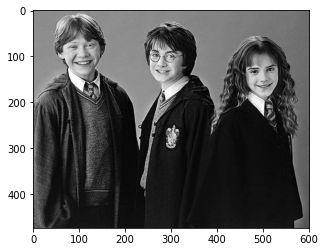

In [12]:
import matplotlib.pyplot as plt

gray_img = cv.imread("/content/drive/MyDrive/CVCourse21/pics/hp.jpeg", 0)
plt.imshow(gray_img, cmap='gray')

In [ ]:
faces = face_clf.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, flags=cv.CASCADE_SCALE_IMAGE)

plot_img = gray_img.copy()

for (x, y, w, h) in faces: 
    cv.rectangle(plot_img, (x, y), (x+w, y+h), (255, 255, 255), 3)

plt.imshow(plot_img, cmap='gray')

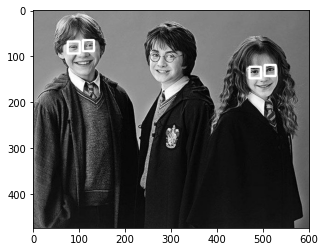

In [14]:
eyes = eye_clf.detectMultiScale(gray_img, scaleFactor=1.1, minNeighbors=5, flags=cv.CASCADE_SCALE_IMAGE)

plot_img = gray_img.copy()
for (x, y, w, h) in eyes: 
    cv.rectangle(plot_img, (x, y), (x+w, y+h), (255, 255, 255), 3)

plt.imshow(plot_img, cmap='gray')

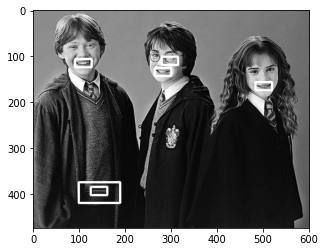

In [15]:
smiles = smile_clf.detectMultiScale(gray_img, scaleFactor=2.5, minNeighbors=5, flags=cv.CASCADE_SCALE_IMAGE)

plot_img = gray_img.copy()
for (x, y, w, h) in smiles: 
    cv.rectangle(plot_img, (x, y), (x+w, y+h), (255, 255, 255), 3)

plt.imshow(plot_img, cmap='gray')

In [17]:
video_capture = cv.VideoCapture("/content/drive/MyDrive/CVCourse21/pics/sample_video.avi")
out_dir = '/content/drive/MyDrive/CVCourse21/viola_jones_demo'
fnums = []
x_s = []
y_s = []
ret = True
fnum = 0
while True:
  ret, frame = video_capture.read()
  fnum += 1
  if ret == False:
    break
  
  gray = cv.cvtColor(frame, cv.COLOR_BGR2GRAY)

  faces = face_clf.detectMultiScale(
        gray,
        scaleFactor=1.1,
        minNeighbors=5,
        minSize=(30, 30),
        flags=cv.CASCADE_SCALE_IMAGE
    )
  
  plot_img = gray.copy()

  if len(faces) > 0:
    x, y, w, h  = faces[0] # detect a single face
    x_s.append(x + w // 2)
    y_s.append(y + h // 2)
    cv.rectangle(plot_img, (x, y), (x+w, y+h), (255, 255, 255), 3)
    fnums.append(fnum)
  
  cv.imwrite("{}/{}.png".format(out_dir, str(fnum - 1).zfill(3)), plot_img)


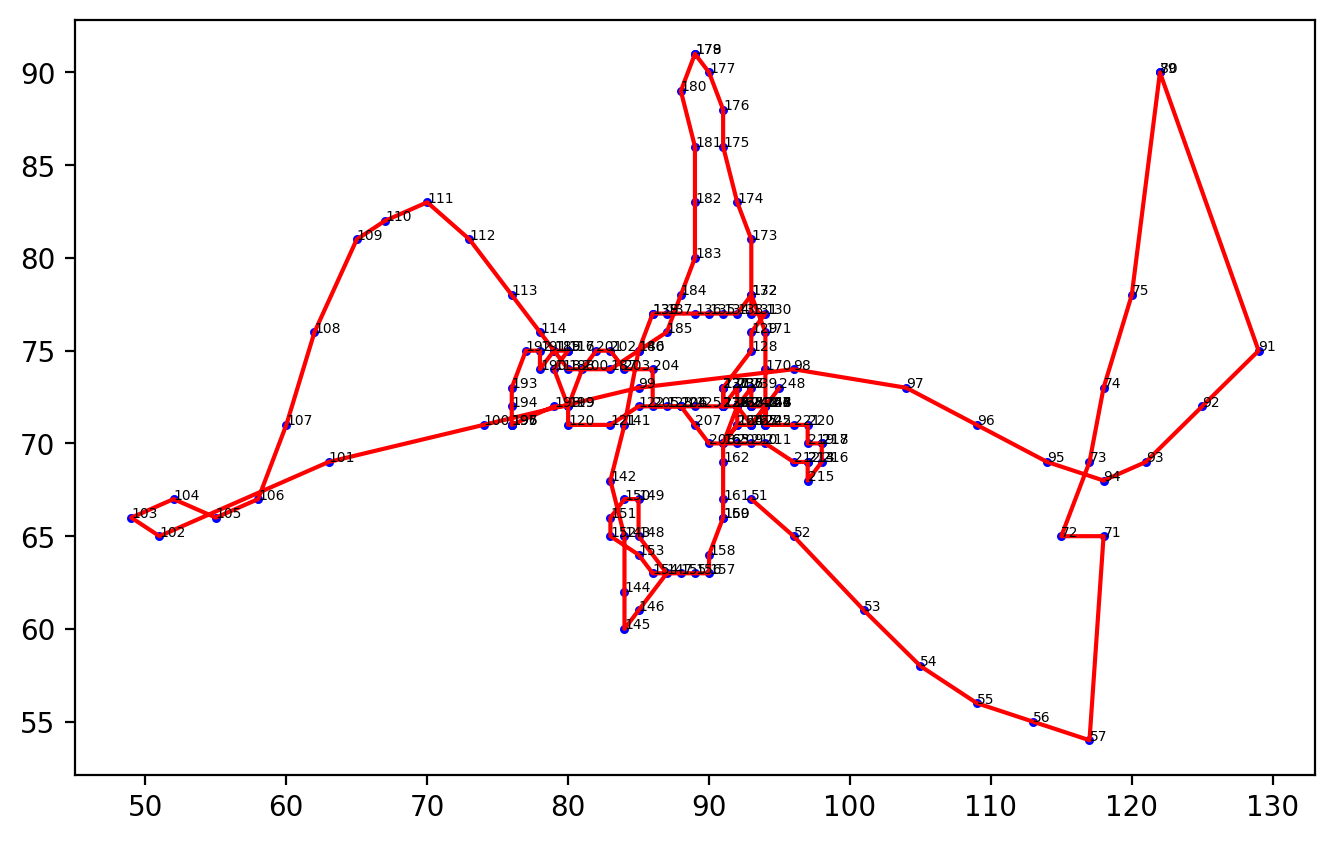

In [18]:
# plot trajectory
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200

plt.scatter(x_s, y_s, s=5, c='blue')
plt.plot(x_s, y_s, c='red')
for i, fnum in enumerate(fnums):
  plt.annotate(str(fnum), (x_s[i], y_s[i]), fontsize=5)

**3. Mean Shift Tracking**

**References**
 * [OpenCV Meanshift](https://docs.opencv.org/3.4/d7/d00/tutorial_meanshift.html) 

 * [Our results](https://drive.google.com/drive/folders/1wwh8l2KKqtrgtLkVTqJtur4q4U2puuOm?usp=sharing)


In [40]:
video_capture = cv.VideoCapture("/content/drive/MyDrive/CVCourse21/pics/sample_video.avi")
out_dir = '/content/drive/MyDrive/CVCourse21/meanshift_demo'


ret_cap, frame = video_capture.read()
print(frame.shape)

# initialize window for face
x, y, w, h = (100, 45, 25, 30)
track_window = (x, y, w, h)

# set the region of interest (ROI)
roi = frame[y: y+h, x: x+w]
roi_hsv = cv.cvtColor(roi, cv.COLOR_BGR2HSV)
mask = cv.inRange(roi_hsv, np.array((0., 60.,32.)), np.array((180.,255.,255.)))

roi_hist = cv.calcHist([roi_hsv],[0],mask,[180],[0,180])
cv.normalize(roi_hist, roi_hist, 0, 255, cv.NORM_MINMAX)



# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv.TERM_CRITERIA_EPS | cv.TERM_CRITERIA_COUNT, 10, 1 )


fnums = []
x_s = []
y_s = []
ret = True
fnum = 0

while True:
  ret_cap, frame = video_capture.read()
  fnum += 1

  if ret_cap == False:
    break
  
  hsv = cv.cvtColor(frame, cv.COLOR_BGR2HSV)
  dst = cv.calcBackProject([hsv], [0], roi_hist, [0,180], 1) # find the best batching displacement
  ret, track_window = cv.meanShift(dst, track_window, term_crit) # use meanshift based on the displacement
  x,y,w,h = track_window
  
  plot_img = frame.copy()

  x_s.append(x + w // 2)
  y_s.append(y + h // 2)
  cv.rectangle(plot_img, (x, y), (x+w, y+h), (255, 255, 255), 3)
  fnums.append(fnum)
  
  cv.imwrite("{}/{}.png".format(out_dir, str(fnum - 1).zfill(3)), plot_img)

(120, 160, 3)


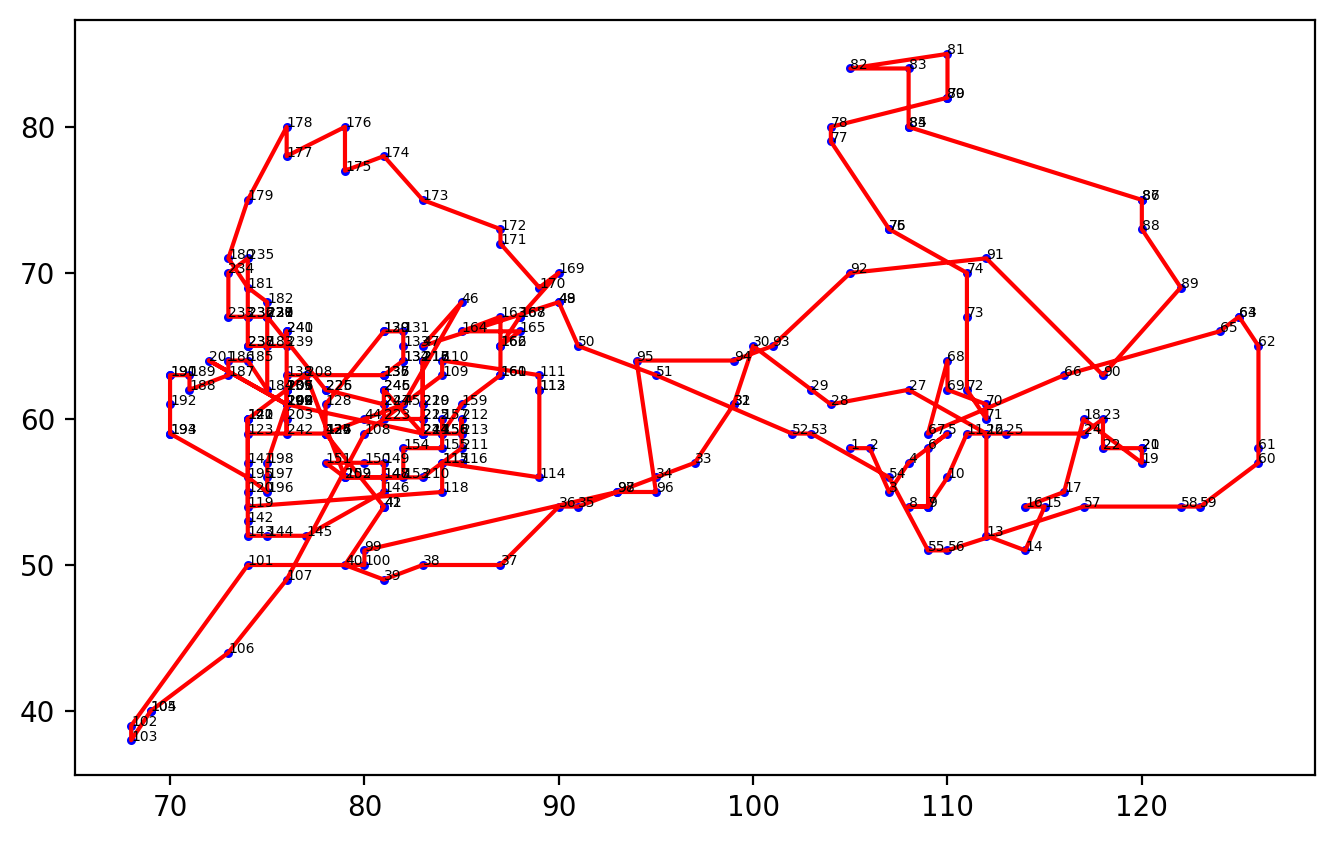

In [41]:
# plot trajectory
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 200

plt.scatter(x_s, y_s, s=5, c='blue')
plt.plot(x_s, y_s, c='red')
for i, fnum in enumerate(fnums):
  plt.annotate(str(fnum), (x_s[i], y_s[i]), fontsize=5)

**4. Lukas-Kanade Optical Flow - Point Based Tracking**

**References**
 * [OpenCV tutorials](https://opencv24-python-tutorials.readthedocs.io/en/latest/py_tutorials/py_video/py_lucas_kanade/py_lucas_kanade.html)
 * [Our results](https://drive.google.com/drive/folders/1tYGuU3P6ZYGm-aE1yCTKc3zLF_cPCER1?usp=sharing)

In [7]:
import cv2
import numpy as np
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt


out_dir = '/content/drive/MyDrive/CVCourse21/lukas_kanade_demo'
cap = cv2.VideoCapture('/content/drive/MyDrive/CVCourse21/pics/slow.mp4')

# params for ShiTomasi corner detection
feature_params = dict( maxCorners = 100,
                       qualityLevel = 0.3,
                       minDistance = 7,
                       blockSize = 7 )

# Parameters for lucas kanade optical flow
lk_params = dict(winSize  = (15,15),
                  maxLevel = 2,
                  criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

# Create some random colors
color = np.random.randint(0,255,(100,3))

# Take first frame and find corners in it
ret, old_frame = cap.read()
old_gray = cv2.cvtColor(old_frame, cv2.COLOR_BGR2GRAY)
p0 = cv2.goodFeaturesToTrack(old_gray, mask = None, **feature_params)


# Create a mask image for drawing purposes
mask = np.zeros_like(old_frame)

fnum = 0
while True:
    ret,frame = cap.read()
    fnum += 1
    if ret == False:
      break 
    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # calculate optical flow
    p1, st, err = cv2.calcOpticalFlowPyrLK(old_gray, frame_gray, p0, None, **lk_params)

    # Select good points
    good_new = p1[st==1]
    good_old = p0[st==1]

    # draw the tracks
    for i,(new, old) in enumerate(zip(good_new, good_old)):
        a,b = new.ravel()
        c,d = old.ravel()
        mask = cv2.line(mask, (a,b),(c,d), color[i].tolist(), 2)
        frame = cv2.circle(frame,(a,b),5,color[i].tolist(),-1)
    img = cv2.add(frame,mask)

    #cv2_imshow(img) # if you want to plot the frame
    cv2.imwrite("{}/{}.png".format(out_dir, str(fnum - 1).zfill(3)), img)

    # Now update the previous frame and previous points
    old_gray = frame_gray.copy()
    p0 = good_new.reshape(-1,1,2)


**5. Condensation Tracking**

Implemented steps:

* **Propagation**. By *parameters['model'] = 1* you can specify if the tracked object is moving. With *params['initial_speed]* you can specify the speed in *y-x* coordinate system.

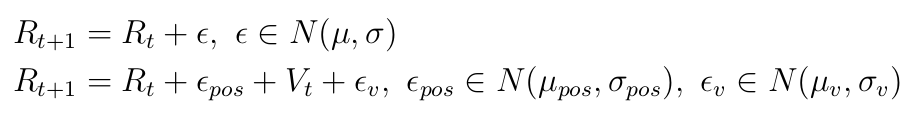


* **Apriori Estimation** Estiamtes the position given the old set of particle weights. 

* **Observation** Aproximate the particle weights given the current frame and the color histogram of the region of interest at the previous step. The Weight is depending on the *chi square* cost between the target histogram (old frame), and the histogram of the content represented in the region of interest in the current frame.

* **Aposteriori estimation** Position estimation given the new set of weights. This is plotted to our frqames, as the white rectangle representing the region of interest.

* **Histogram update** Update the target histogram given the current frame and the position of the ROI (as the aposteriori estimation).

* **Particle resampling** Remove the particles with very low weights, keeping the particles with lower costs to the target histogram.

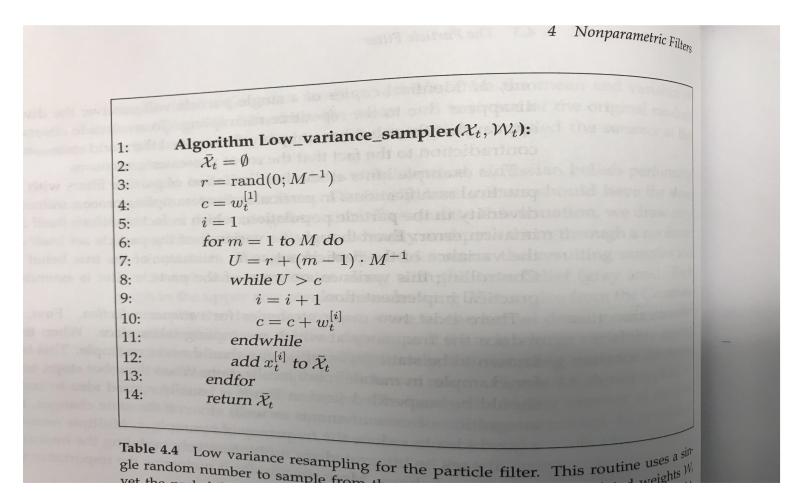

**References**
* [Scientific paper](https://drive.google.com/file/d/15z2yBIQ12Qby_S1Wb2RD8sHI2R6tfg-b/view?usp=sharing)
* [Our reults](https://drive.google.com/drive/folders/1wN-9rHq3SNPNXXb4EqbND3qMSqWyd9H7?usp=sharing)

In [90]:
import cv2 as cv
import numpy as np 
from math import floor, exp


# defines the chi2 cost between 2 histograms
def chi2_cost(hist1, hist2):
  dist_1 = np.square(hist1 - hist2)
  dist_2 = np.finfo(float).eps + np.add(hist1, hist2)
  dist = np.sum(np.divide(dist_1, dist_2))
  return dist


# computes the color histogram in the hiven bounding box
# and the stacks them horizontally in a single dim array
def color_hist(x_min, y_min, x_max, y_max, frame, num_bins):
  roi = frame[y_min: y_max, x_min: x_max, :]
  b, g, r = cv.split(roi)
  hb = cv2.calcHist(b, [0], None, [num_bins], [0,256])
  hg = cv2.calcHist(g, [0], None, [num_bins], [0,256])
  hr = cv2.calcHist(r, [0], None, [num_bins], [0,256])

  out = np.zeros(3 * num_bins)
  out[:num_bins] = hr[:, 0]
  out[num_bins: 2 * num_bins] = hg[:, 0]
  out[2*num_bins:] = hb[:, 0]
  out = out / np.sum(out)
  return out


# estimation function blending particle position and their weights
def estimate(patricles, particles_w):
  m = particles.T @ particles_w
  return m.T


# observe function. Computes histograms for all particles and updates weights based on cost
# H and W are the dimensions of the initial bounding box
def observe(particles, frame, H, W, num_bins, hist_target, sigma_observe):
  h, w , _ = frame.shape
  num_particles = particles.shape[0]

  hist_part = np.zeros((num_particles, 3 * num_bins))
  for i in range(num_particles):
    x_min = min(max(0, floor(particles[i, 1] - 0.5 * W)), w - 1)
    y_min = min(max(0, floor(particles[i, 0] - 0.5 * H)), h - 1)
    x_max = min(max(0, floor(particles[i, 1] + 0.5 * W)), w - 1)
    y_max = min(max(0, floor(particles[i, 0] + 0.5 * H)), h - 1)
    hist_part[i, :] = color_hist(x_min, y_min, x_max, y_max, frame, num_bins)

  particles_w = np.zeros(num_particles)
  for i in range(num_particles):
    cost = chi2_cost(hist_target, hist_part[i, :])
    # gaussian weight based on cost , wrt to the measurement noise model
    particles_w[i] = (1 / (np.sqrt(2 * np.pi) * sigma_observe)) * np.exp(-0.5 * (cost / sigma_observe) *(cost / sigma_observe))
  

  # normalize to a probability distribution
  particles_w = 1 / np.sum(particles_w) * particles_w
  return particles_w


# propagate the particles wrt the motion model you chose
def propagate(particles, size_frame, params):
  num_part, state_dim = particles.shape
  if params['model'] == 0:
    # linear motion (just add the speed and noise)
    A = np.eye(2)
    particles = A @ particles.T + (np.ones((state_dim, num_part)) - 2 * np.random.rand(state_dim, num_part)) * params['sigma_position']
    particles = particles.T
  else:
    A = np.array([
                  [1, 0, 1, 0],
                  [0, 1, 0, 1],
                  [0, 0, 1, 0],
                  [0, 0, 0, 1]
    ])
    # movement for both position and velocity
    noise = np.zeros((4, num_part))
    noise[:2, :] = np.random.rand(2, num_part) * params['sigma_position']
    noise[2:, :] = np.random.rand(2, num_part) * params['sigma_velocity']
    particles = A @ particles.T + noise
    particles = particles.T

  # make sure particles don't move outside the frame
  for i in range(num_part):
    if particles[i, 0] < 0:
      particles[i, 0] = 0
    elif particles[i, 0] > size_frame[0]:
      particles[i, 0] = size_frame[0]
    elif particles[i, 1] < 0:
      particles[i, 1] = 0
    elif particles[i, 1] > size_frame[1]:
      particles[i, 1] = size_frame[1]
  return particles


# resample particles keeping those with higher weight
def resample(particles, particles_w):
  num_part = particles.shape[0]
  r = 1 / num_part * np.random.rand()
  c = particles_w[0]
  i = 0
  sampled_part = []
  sampled_part_w = []
  for m in range(num_part):
    U = r + 1/num_part * (m-1)
    while U > c:
      i += 1
      c += particles_w[i]
    
    sampled_part.append(particles[i, :])
    sampled_part_w.append(particles_w[i])

  sampled_part_w = np.array(sampled_part_w)
  sampled_part = np.array(sampled_part)
  sampled_part_w = 1 / np.sum(sampled_part_w) * sampled_part_w

  return sampled_part, sampled_part_w


In [16]:
frame = cv.imread("/content/drive/MyDrive/CVCourse21/pics/curve.jpg")
ch = color_hist(0, 0, 100, 100, frame, 16)
print(ch.shape)

(48,)


In [94]:
video_capture = cv.VideoCapture("/content/drive/MyDrive/CVCourse21/pics/sample_video.avi")
out_dir = '/content/drive/MyDrive/CVCourse21/condensation_demo'


params = {
    'alpha': 0.1,
    'num_bins':16,
    'sigma_observe': 0.1,
    'sigma_position':15,
    'sigma_velocity': 1,
    'initial_velocity': np.array([1, 10]),
    'model': 0, # velocity + noise
    'num_particles': 1000,

}


ret_cap, frame = video_capture.read()
print(frame.shape)

# initialize window for face
x, y, W, H = (100, 45, 25, 30)
track_window = (x, y, W, H)
hist = color_hist(x, y, x + W, y + H, frame, params['num_bins'])

if params['model'] == 0:
  state_dim = 2
else:
  state_dim = 4

# number of frames in the video
num_frames = 247
state_apriori = np.zeros((num_frames, state_dim))
state_aposteriori = np.zeros((num_frames, state_dim))
state_apriori[0, 0] = floor(y + 0.5 * H)
state_apriori[0, 1] = floor(x + 0.5 * W)

if params['model'] == 1:
  state_apriori[0, 2:] = params['initial_velocity']

particles = np.zeros((params['num_particles'], state_dim))
particles_w = np.zeros(params['num_particles'])

#initialize particles
for i in range(params['num_particles']):
  particles[i, :] = state_apriori[0, :]
  particles_w[i] = 1/params['num_particles']



fnums = []
x_s = []
y_s = []
ret = True
fnum = 0

while True:
  ret_cap, frame = video_capture.read()
  fnum += 1

  if ret_cap == False:
    break
  else:
    heightFrame, widthFrame, _ = frame.shape

  # 1. propagate the particles
  particles = propagate(particles, frame.shape, params)

  # 2.estimate
  state_apriori[fnum - 1, :] = estimate(particles, particles_w)

  # 3. observe
  particles_w = observe(particles, frame, H, W, params['num_bins'], hist, params['sigma_observe'])

  # 4. update estimation
  state_aposteriori[fnum - 1, :] = estimate(particles, particles_w)
  
  # 5. update histogram
  local_xmin = min(max(0, floor(state_aposteriori[fnum - 1,1] - 0.5 * W)), widthFrame)
  local_ymin = min(max(0, floor(state_aposteriori[fnum - 1,0] - 0.5 * H)), heightFrame)
  local_xmax = min(max(0, floor(state_aposteriori[fnum - 1,1] + 0.5 * W)), widthFrame)
  local_ymax = min(max(0, floor(state_aposteriori[fnum - 1,0] + 0.5 * H)), heightFrame)
  current_hist = color_hist(local_xmin, local_ymin, local_xmax , local_ymax, frame, params['num_bins'])
  print(fnum, local_xmin, local_ymin)

  # linear blend to the old one
  hist = (1 - params['alpha']) * hist + params['alpha'] * current_hist

  # 6. resample
  particles, particles_w = resample(particles, particles_w)

  plot_img = frame.copy()

  cv.rectangle(plot_img, (local_xmin, local_ymin), (local_xmax, local_ymax), (255, 255, 255), 3)
  cv.imwrite("{}/{}.png".format(out_dir, str(fnum - 1).zfill(3)), plot_img)

(120, 160, 3)
1 100 45
2 103 45
3 102 45
4 103 44
5 104 44
6 103 44
7 102 44
8 103 44
9 104 45
10 103 44
11 104 44
12 105 44
13 105 44
14 105 48
15 97 54
16 100 54
17 104 51
18 111 46
19 108 50
20 109 46
21 102 51
22 95 63
23 89 65
24 103 50
25 103 47
26 102 47
27 99 48
28 95 47
29 94 46
30 90 46
31 86 46
32 89 44
33 84 42
34 85 40
35 83 38
36 78 37
37 75 34
38 73 33
39 71 35
40 68 34
41 67 35
42 65 38
43 65 40
44 67 42
45 68 43
46 69 45
47 69 47
48 73 47
49 76 46
50 80 46
51 83 41
52 89 38
53 91 36
54 97 31
55 100 30
56 105 29
57 110 29
58 112 30
59 117 31
60 117 33
61 121 35
62 120 39
63 121 41
64 119 40
65 122 40
66 117 39
67 119 39
68 117 35
69 110 34
70 112 36
71 109 34
72 107 38
73 108 40
74 110 45
75 111 50
76 112 52
77 112 54
78 112 54
79 111 54
80 111 55
81 113 58
82 115 58
83 118 55
84 117 53
85 119 52
86 121 49
87 122 47
88 124 44
89 125 42
90 123 40
91 123 36
92 122 34
93 119 32
94 117 31
95 113 32
96 110 33
97 102 32
98 91 29
99 82 28
100 70 26
101 54 19
102 47 17
103 40 1